# Forecasting Multiple Seasonalities

## Using BATS and TBATS models in Python

When dealing with time series, we often encounter seasonality. **Seasonality** is defined as a periodical variation in our series. It is a cycle that occurs over a fixed period in our series. 

Now things can get more complicated when we are working with high frequency data. For example, an hourly time series can exhibit a daily, weekly, monthly and yearly seasonality, meaning that we now have multiple seasonal periods. 

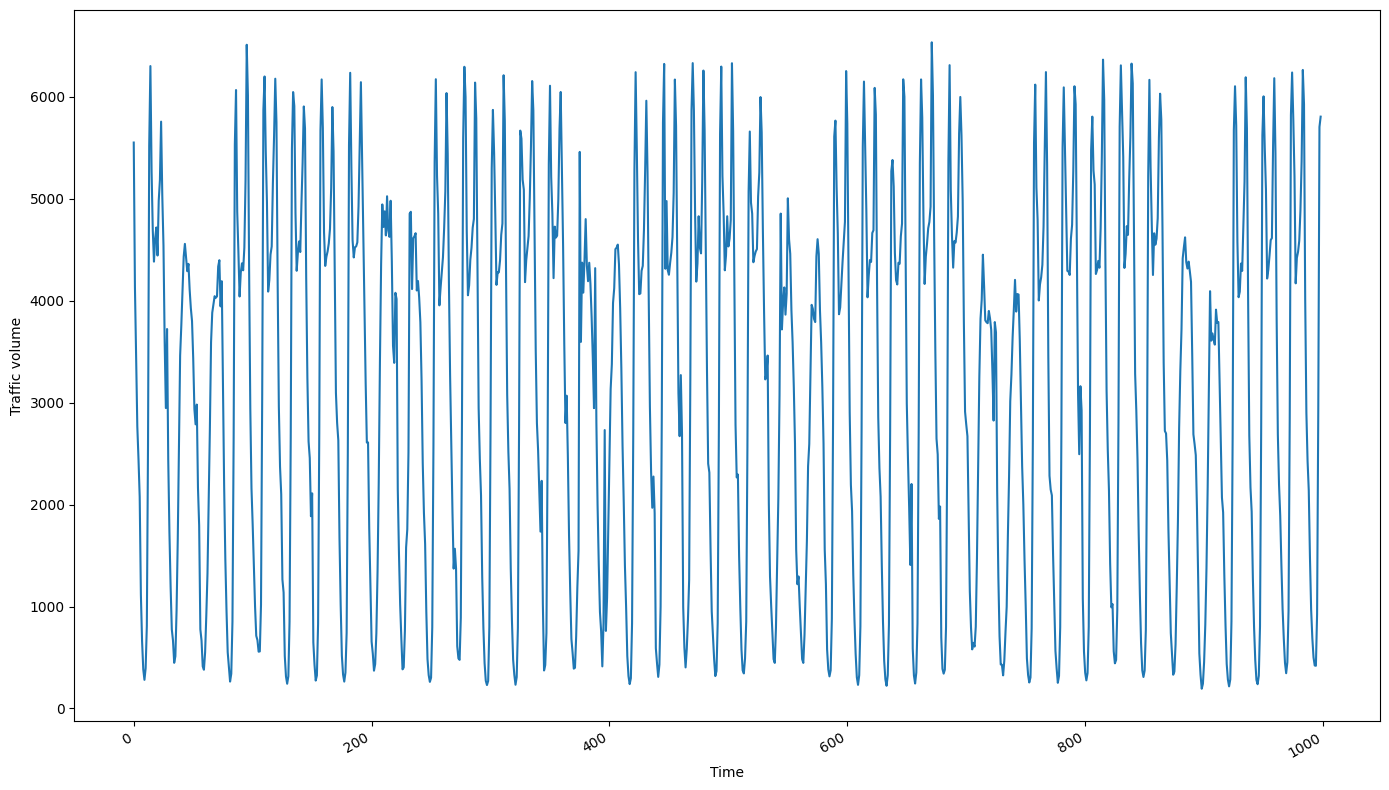

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


url='https://raw.githubusercontent.com/marcopeix/time-series-analysis/master/data/daily_traffic.csv'

data = pd.read_csv(url)
data = data.dropna()

fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(data['traffic_volume'])
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

# plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

In [3]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(data['traffic_volume'])
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

Looking at the data above, we can see that we have two seasonal periods! First, we have a daily seasonality, as we see that more cars travel on the road during the day than during the night. Second, we have a weekly seasonality, as traffic volume is higher during weekdays than during the weekend.

In this case, a SARIMA model cannot be used, because we can only specify one seasonal periods, whereas we definitely have two seasonal periods in our data: a daily seasonality and a weekly seasonality.

We thus turn our attention to **BATS and TBATS models**. Using these models, we can fit and forecast time series that have more than one seasonal period.

In this article, we first explore the theory behind BATS and TBATS, and then apply them to forecast the hourly traffic volume for the next seven days. Let’s get started!

### The Intuition behind BATS and TBATS

**BATS:**

The acronym BATS refers to the method: exponential smoothing state-space model with Box-Cox transformation, ARMA errors, Trend and Seasonal Components. This means:
- Exponential Smoothing: The general idea behind these forecasting methods is that future values are a weighted average of past values, with the weights decaying exponetially as we go back in time.
- State-Space: Modelling is a framework in which a time series is seen as a set of observed data that is influenced by a set of unobserved factors. The state-space model then expresses the relationship between the two sets. Again, this must be seen as a framework, as an ARMA model can be expresses as a state-space model.
- Box-Cox transformation is a power transformation that helps make the series stationary, by stabilizing the variance and mean over time. 
- ARMA errors is a process in which we apply an ARMA model on the residuals of the time series in order to find any unexplained relationship. Usually, the residuals of a model should be totally random, unless some information was not captured by the model. Here, we use an ARMA model to capture any remaining information in the residuals. 

To summarize, BATS is an extension of exponential smoothing methods that combines a Box-Cox transformation to hanbdle non-linear data and uses an ARMA model to capture autocorrelation in the residuals. 

The advantage of usin BATS is that it can treat non-linear data, solve the autocorrelation problem in residuals since it uses an ARMA model, and it can take into account multiple seasonal periods.

However the seasonal periods must be integer numbers, otherwise BATS cannot be applied. For example, suppose that you have weekly data with a yearly seasonality, then our period is 365.25/7 which is approximately 52.2. In that case, BATS is ruled out. 

Furthermoere, BATS can take a long time to fit if the seasonal period is very large, meaning that it is not suitable if you have hourly data with a monthly (period would be 730).

**TBATS:**

The acronym TBATS stands for Trigonometric seasonlity, Box-Cox transformation, ARMA errors, Trend and Seasonal components. 

It uses the same components as the BATS model, however it represents each seasonal period as a trigonometric representation based on Fourier series. This allows the model to fit large seasonal periods and non-integer seasonal periods.

It is thus a better choice when dealing with high-frequency data and it usually fits faster than BATS.

In [4]:
y = data['traffic_volume']

fh = np.arange(1, 168)

In [5]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, test_size=168)

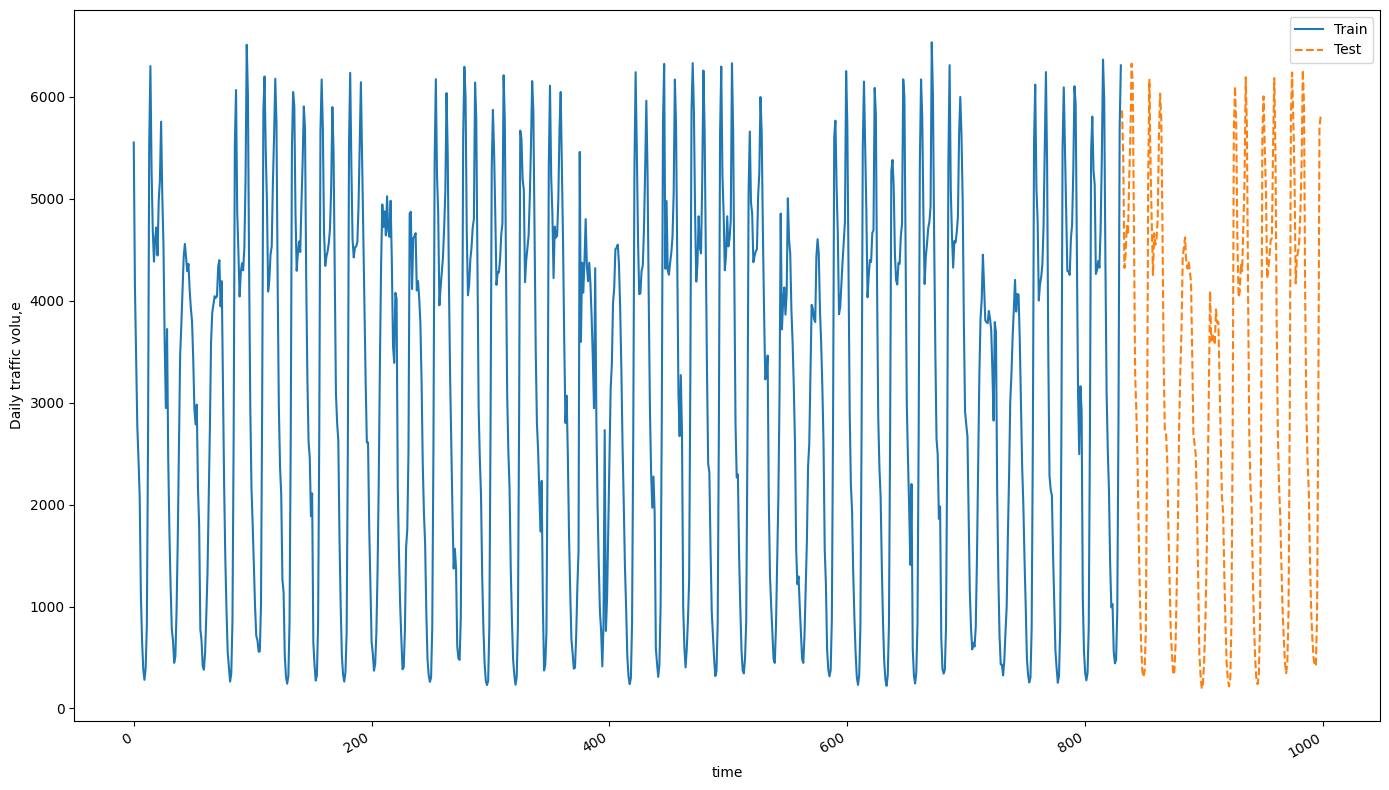

In [6]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(y_train, ls='-', label='Train')
ax.plot(y_test, ls='--', label='Test')
ax.set_xlabel('time')
ax.set_ylabel('Daily traffic volu,e')
ax.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

### Modeling 

Before we implement our more complex BATS and TBATS models, it’s always a good idea to have a baseline model. That way, we can determine if our more complex forecasting methods are actually performant.

Here, the simplest baseline I can think of is simply repeating the last week of data from the training set into the future.

$$ y_{pred-baseline} = y_{train}[-168:].values $$

In [7]:
y_pred_baseline = y_train[-168:].values

#### BATS

We first import the BATS model from sktime. Then, we specify the parameters of the model for training. Here, we want to use the Box-Cox transformation as we are dealing with non-linear data. Then, since our dataset does not have an apparent trend, we remove those components from the model. Finally, we specify the seasonal periods, which are 24 (for the daily seasonality) and 168 (for the weekly seasonality).

Once the model is specified, we simply fit it on the training set and generate the predictions over the forecast horizon.

In [8]:
from sktime.forecasting.bats import BATS

forecaster = BATS(use_box_cox=True,
                  use_trend=False,
                  use_damped_trend=False,
                  sp=[24, 168])
forecaster.fit(y_train)

y_pred_BATS = forecaster.predict(fh)

#### TBATS



In [10]:
from sktime.forecasting.tbats import TBATS

forecaster = TBATS(use_box_cox=True,
                   use_trend=False,
                   use_damped_trend=False,
                   sp=[24, 168])
forecaster.fit(y_train)

y_pred_TBATS = forecaster.predict(fh)

### Evaluating the Performance

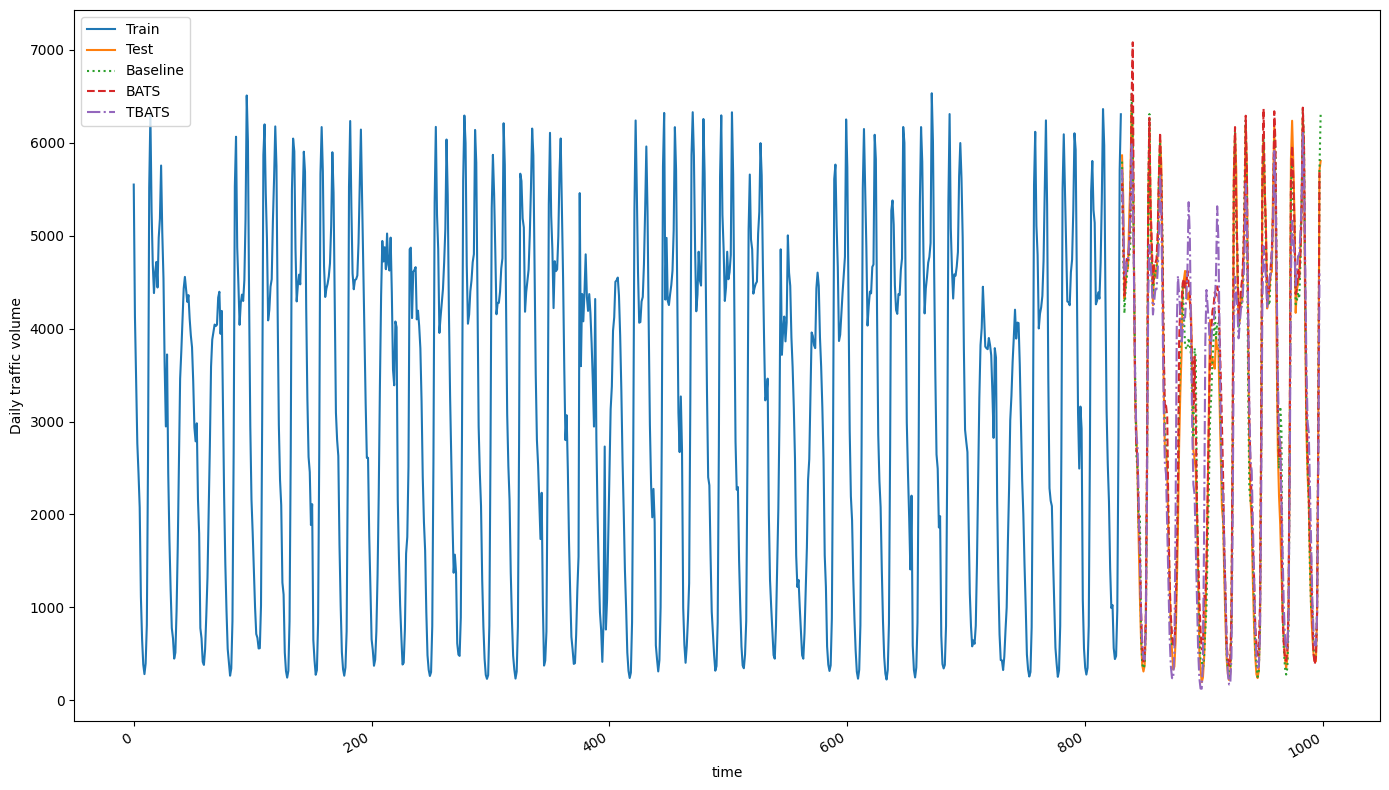

In [11]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(y_train, ls='-', label='Train')
ax.plot(y_test, ls='-', label='Test')
ax.plot(y_test.index, y_pred_baseline, ls=':', label='Baseline')
ax.plot(y_pred_BATS, ls='--', label='BATS')
ax.plot(y_pred_TBATS, ls='-.', label='TBATS')
ax.set_xlabel('time')
ax.set_ylabel('Daily traffic volume')
ax.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

Looking at the figure above, it seems that all of our models generate very similar predictions, as the lines are overlapping. It is very hard to determine which model performs best just by looking at the plot.

We can optionally zoom in on the test set to better visualize the predictions.

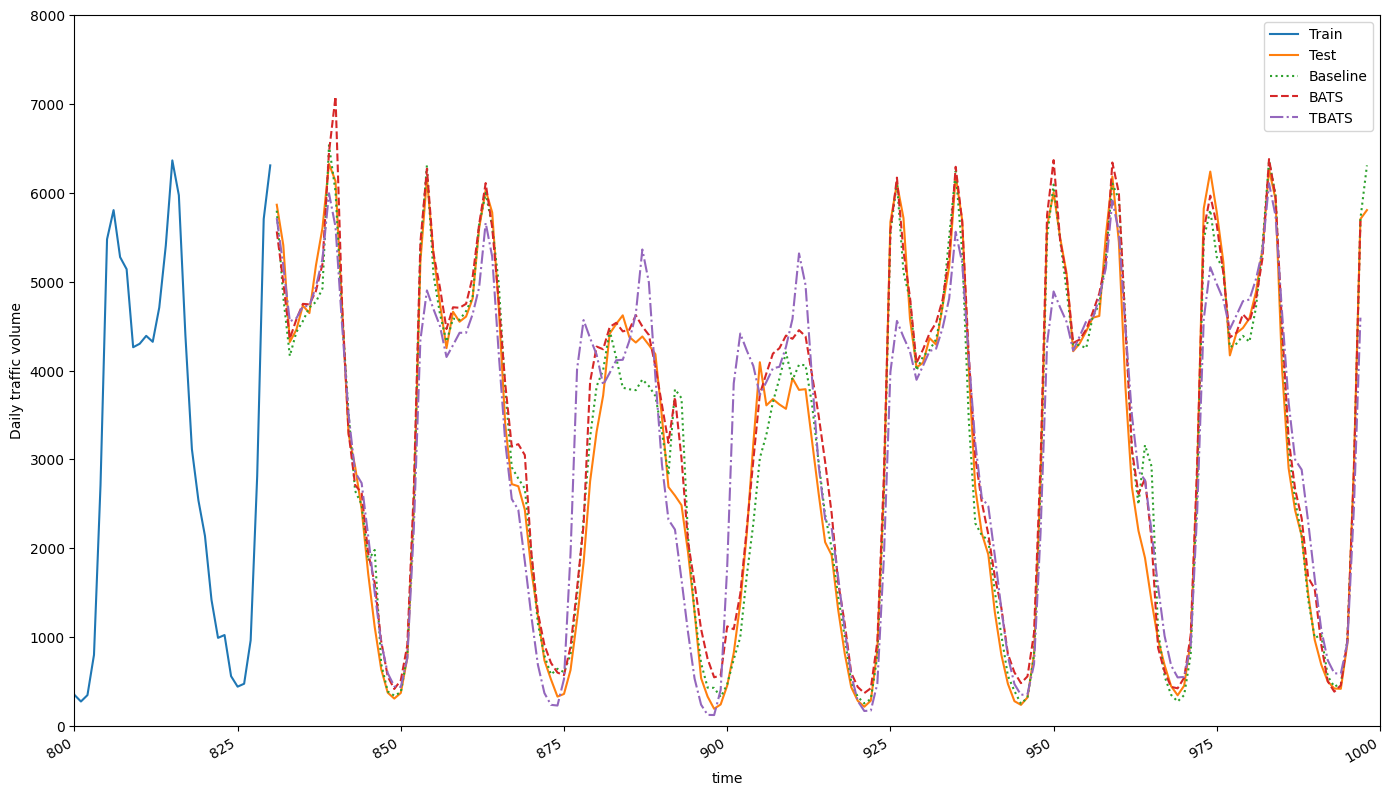

In [12]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(y_train, ls='-', label='Train')
ax.plot(y_test, ls='-', label='Test')
ax.plot(y_test.index, y_pred_baseline, ls=':', label='Baseline')
ax.plot(y_pred_BATS, ls='--', label='BATS')
ax.plot(y_pred_TBATS, ls='-.', label='TBATS')
ax.set_xlabel('time')
ax.set_ylabel('Daily traffic volume')
ax.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout()

plt.xlim(800, 1000)
plt.ylim(0, 8000)

plt.show()

Looking at the figure above, we first notice that both models indeed model a double seasonality, which is great in itself! Also, it seems that BATS does a better job at predicting the future, since TBATS seems to sometimes overshoot or undershoot. Note also that the baseline model closely follows the curve of actual values.

We now compute an error metric to determine the best model and compare their performance. In this case, we use the mean absolute percentage error (MAPE), for its ease of interpretation. 



In [13]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100,2)

In [14]:
mape_baseline = mape(y_test, y_pred_baseline)
mape_BATS = mape(y_test, y_pred_BATS)
mape_TBATS = mape(y_test, y_pred_TBATS)

print(f'MAPE from baseline: {mape_baseline}')
print(f'MAPE from BATS: {mape_BATS}')
print(f'MAPE from TBATS: {mape_TBATS}')

MAPE from baseline: 11.97
MAPE from BATS: 19.58
MAPE from TBATS: 29.53


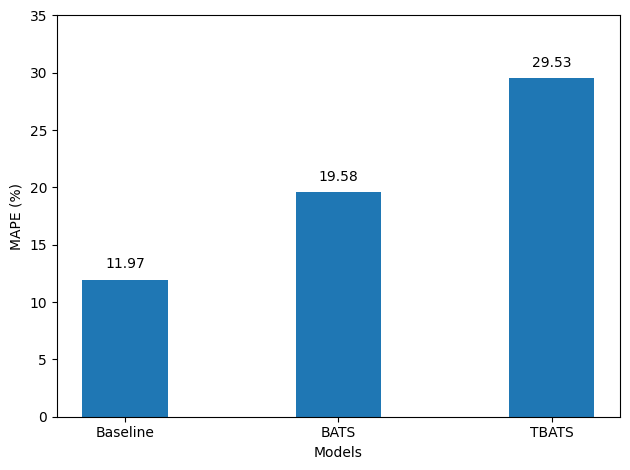

In [15]:
fig, ax = plt.subplots()

x = ['Baseline', 'BATS', 'TBATS']
y = [mape_baseline, mape_BATS, mape_TBATS]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 35)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

From the figure above, we can see that BATS performed better than TBATS, which is to be expected as we observed from the plot. However, we see that the baseline model is the best performing model, achieving a MAPE of 11.97%.

That’s a bit anticlimactic, but let’s understand why this happened.

It is possible that our dataset is too small. It might be that the sample that we used for testing turns out to favor the baseline model. One way to verify would be to forecast multiple 168 hour-horizon, to see if the baseline model still outperforms the rest.

Also, it can be that we were too strict with the models’ parameters. Here, we forced both models to use Box-Cox transformations and remove the trend component. However, we could have not specified those parameters, and the model would have tried both possibilities for each parameter and select the one with the lowest AIC (Akaike’s Information Criterion). While this makes the training process longer, it might also result in better performance from BATS and TBATS.

Nevertheless, a key takeaway is that a building a baseline model is very important for any forecasting project.